In [ ]:
#Import packages
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD,RMSprop,Adam,Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
#accessing directory
train = os.path.join('web/training_set')
test = os.path.join('web/test_set')

# directory with our training pictures
train_saree = os.path.join(train, 'saree')  
train_shirt = os.path.join(train, 'shirt')
train_tshirt = os.path.join(train, 'tshirt')

# directory with our test pictures
test_saree = os.path.join(test, 'saree')  
test_shirt = os.path.join(test, 'shirt')
test_tshirt = os.path.join(test, 'tshirt')

In [ ]:
#over viewing details about dataset
saree_train = len(os.listdir(train_saree))
shirt_train = len(os.listdir(train_shirt))
tshirt_train = len(os.listdir(train_shirt))

saree_test = len(os.listdir(test_saree))
shirt_test = len(os.listdir(test_shirt))
tshirt_test = len(os.listdir(test_shirt))

total_train = saree_train + shirt_train + tshirt_train
total_val = saree_test + shirt_test + tshirt_test

print('total training saree images:', saree_train)
print('total training shirt images:', shirt_train)
print('total training tshirt images:', tshirt_train,'\n')

print('total test saree images:', saree_test)
print('total test shirt images:', shirt_test)
print('total test tshirt images:', tshirt_test,'\n')

print("Total training images:", total_train)
print("Total validation images:", total_val)

In [ ]:
# Generator for our training data
train_image_generator = ImageDataGenerator(rescale=1./255)
# Generator for our test data
test_image_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
#defining batch size and epochs for model and normalizing all images
batch_size = 25
epochs = 20
IMG_HEIGHT = 300
IMG_WIDTH = 150

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

In [ ]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

In [ ]:
sample_training_images, _ = next(train_data_gen)

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 6, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
plotImages(sample_training_images[:6])

### Creating the cnn model

In [11]:
def cnn_mod():
    model = Sequential([
        Conv2D(16, 3, padding='same', activation='relu',input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
        MaxPooling2D((2,2),2),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D((2,2),2),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D((2,2),2),
        Flatten(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    return model

In [12]:
#model summry
model = cnn_mod()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 75, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 75, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 42624)             0

In [13]:
#function created for callbacks
def callbacks():
    checkpoint = ModelCheckpoint('web/web.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
    earlystopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience= 5,
                              verbose=1,
                              mode='max',
                              restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=0.2,
                             patience=5,
                             verbose=1,
                             mode='max',
                             min_delta=0.0001)

    callbacks = [checkpoint,earlystopping,reduce_lr]
    return callbacks

In [14]:
#instantiate callbacks
callbacks = callbacks()

### SGD model with momentum

In [15]:
SGDm = SGD(learning_rate=0.01, momentum=0.01,nesterov=False)

In [16]:
#instantiate model
model_SGDm = cnn_mod()

In [17]:
#Compile the model
model_SGDm.compile(optimizer=SGDm,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [18]:
#Train the model
SGDm_mod = model_SGDm.fit_generator(
    train_data_gen,
    epochs=epochs,
    validation_data=test_data_gen,
    callbacks =callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 84 steps, validate for 3 steps
Epoch 1/20
83/84 [============================>.] - ETA: 0s - loss: 1.0813 - accuracy: 0.4048
Epoch 00001: val_accuracy improved from -inf to 0.78333, saving model to web/web.h5
84/84 [==============================] - 38s 454ms/step - loss: 1.0807 - accuracy: 0.4052 - val_loss: 1.0198 - val_accuracy: 0.7833
Epoch 2/20
83/84 [============================>.] - ETA: 0s - loss: 0.9727 - accuracy: 0.5639
Epoch 00002: val_accuracy improved from 0.78333 to 0.83333, saving model to web/web.h5
84/84 [==============================] - 39s 467ms/step - loss: 0.9704 - accuracy: 0.5662 - val_loss: 0.8097 - val_accuracy: 0.8333
Epoch 3/20
83/84 [============================>.] - ETA: 0s - loss: 0.7630 - accuracy: 0.7051
Epoch 00003: val_accuracy did not improve from 0.83333
84/84 [==============================] - 40s 481ms/step - los

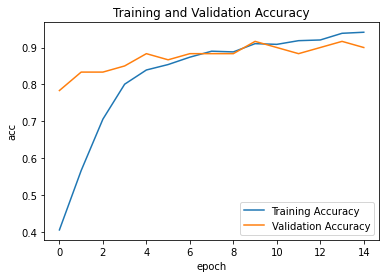

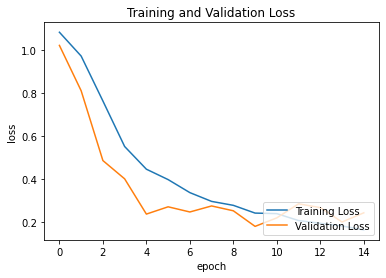

In [19]:
#Visualize training results
acc = plt.plot(SGDm_mod.history['accuracy'])
val_acc = plt.plot(SGDm_mod.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

loss= plt.plot(SGDm_mod.history['loss'])
val_loss=plt.plot(SGDm_mod.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### Nesterov Accelerated Gradient Descent

In [20]:
NESTROV= SGD(learning_rate=0.01, momentum=0.01, nesterov= True)

In [21]:
#instantiate model
model_NESTROV = cnn_mod()

In [22]:
#Compile the model
model_NESTROV.compile(optimizer=NESTROV,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [23]:
#Train the model
NESTROV_mod = model_NESTROV.fit_generator(
    train_data_gen,
    epochs=epochs,
    validation_data=test_data_gen,
    callbacks =callbacks
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 84 steps, validate for 3 steps
Epoch 1/20
83/84 [============================>.] - ETA: 0s - loss: 1.0537 - accuracy: 0.4453
Epoch 00001: val_accuracy did not improve from 0.91667
84/84 [==============================] - 41s 490ms/step - loss: 1.0526 - accuracy: 0.4448 - val_loss: 0.7912 - val_accuracy: 0.7333
Epoch 2/20
83/84 [============================>.] - ETA: 0s - loss: 0.7552 - accuracy: 0.6559
Epoch 00002: val_accuracy did not improve from 0.91667
84/84 [==============================] - 41s 489ms/step - loss: 0.7542 - accuracy: 0.6571 - val_loss: 0.5257 - val_accuracy: 0.7167
Epoch 3/20
83/84 [============================>.] - ETA: 0s - loss: 0.5378 - accuracy: 0.7725
Epoch 00003: val_accuracy did not improve from 0.91667
84/84 [==============================] - 42s 496ms/step - loss: 0.5370 - accuracy: 0.7724 - val_loss: 0.3722 - val_accuracy: 0.8500
Epoch 4/20
83/84 [============================>.] - ETA: 0s - loss

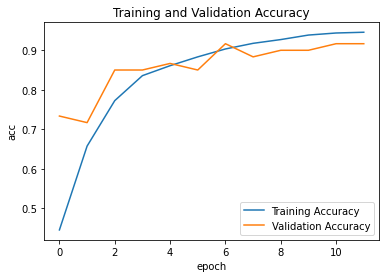

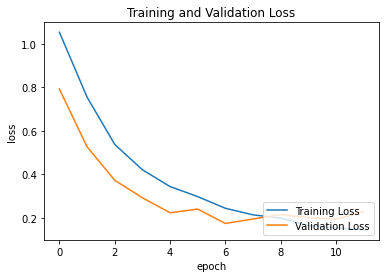

In [24]:
#Visualize training results
acc = plt.plot(NESTROV_mod.history['accuracy'])
val_acc = plt.plot(NESTROV_mod.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

loss= plt.plot(NESTROV_mod.history['loss'])
val_loss=plt.plot(NESTROV_mod.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### RMSPROP

In [25]:
RMS= RMSprop(learning_rate=0.01)

In [26]:
#instantiate model
model_RMS = cnn_mod()

In [27]:
#Compile the model
model_RMS.compile(optimizer=RMS,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [28]:
#Train the model
RMS_mod = model_RMS.fit_generator(
    train_data_gen,
    epochs=epochs,
    validation_data=test_data_gen,
    callbacks =callbacks
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 84 steps, validate for 3 steps
Epoch 1/20
83/84 [============================>.] - ETA: 0s - loss: 4.2833 - accuracy: 0.5340
Epoch 00001: val_accuracy did not improve from 0.91667
84/84 [==============================] - 39s 462ms/step - loss: 4.2387 - accuracy: 0.5371 - val_loss: 0.6581 - val_accuracy: 0.7333
Epoch 2/20
83/84 [============================>.] - ETA: 0s - loss: 0.7219 - accuracy: 0.7186
Epoch 00002: val_accuracy did not improve from 0.91667
84/84 [==============================] - 38s 454ms/step - loss: 0.7210 - accuracy: 0.7205 - val_loss: 0.6397 - val_accuracy: 0.7333
Epoch 3/20
83/84 [============================>.] - ETA: 0s - loss: 0.5873 - accuracy: 0.8082
Epoch 00003: val_accuracy did not improve from 0.91667
84/84 [==============================] - 38s 454ms/step - loss: 0.5825 - accuracy: 0.8095 - val_loss: 0.6587 - val_accuracy: 0.8500
Epoch 4/20
83/84 [============================>.] - ETA: 0s - loss

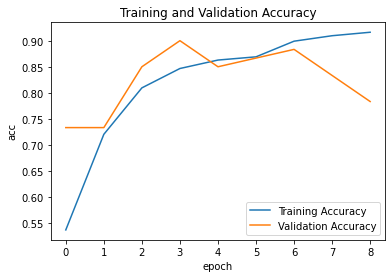

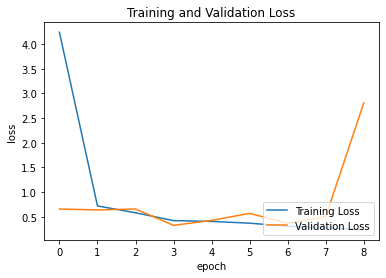

In [29]:
#Visualize training results
acc = plt.plot(RMS_mod.history['accuracy'])
val_acc = plt.plot(RMS_mod.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

loss= plt.plot(RMS_mod.history['loss'])
val_loss=plt.plot(RMS_mod.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### Adam

In [30]:
ADAM = Adam(learning_rate=0.01)

In [31]:
#instantiate model
model_ADAM = cnn_mod()

In [32]:
#Compile the model
model_ADAM.compile(optimizer=ADAM,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [33]:
#Train the model
ADAM_mod = model_ADAM.fit_generator(
    train_data_gen,
    epochs=epochs,
    validation_data=test_data_gen,
    callbacks =callbacks
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 84 steps, validate for 3 steps
Epoch 1/20
83/84 [============================>.] - ETA: 0s - loss: 1.3602 - accuracy: 0.3253
Epoch 00001: val_accuracy did not improve from 0.91667
84/84 [==============================] - 38s 448ms/step - loss: 1.3571 - accuracy: 0.3252 - val_loss: 1.0999 - val_accuracy: 0.3333
Epoch 2/20
83/84 [============================>.] - ETA: 0s - loss: 1.0996 - accuracy: 0.3311
Epoch 00002: val_accuracy did not improve from 0.91667
84/84 [==============================] - 37s 443ms/step - loss: 1.0995 - accuracy: 0.3314 - val_loss: 1.0996 - val_accuracy: 0.3333
Epoch 3/20
83/84 [============================>.] - ETA: 0s - loss: 1.0990 - accuracy: 0.3369
Epoch 00003: val_accuracy did not improve from 0.91667
84/84 [==============================] - 37s 446ms/step - loss: 1.0990 - accuracy: 0.3348 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 4/20
83/84 [============================>.] - ETA: 0s - loss

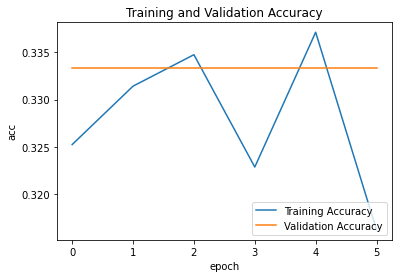

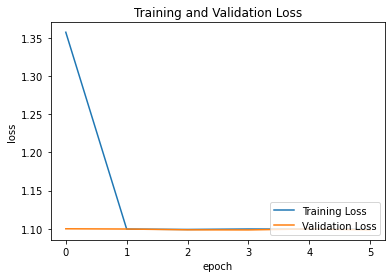

In [34]:
#Visualize training results
acc = plt.plot(ADAM_mod.history['accuracy'])
val_acc = plt.plot(ADAM_mod.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

loss= plt.plot(ADAM_mod.history['loss'])
val_loss=plt.plot(ADAM_mod.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### Nadam

In [35]:
NADAM = Nadam(learning_rate=0.01)

In [36]:
#instantiate model
model_NADAM = cnn_mod()

In [37]:
#Compile the model
model_NADAM.compile(optimizer=NADAM,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [38]:
#Train the model
NADAM_mod = model_NADAM.fit_generator(
    train_data_gen,
    epochs=epochs,
    validation_data=test_data_gen,
    callbacks =callbacks
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 84 steps, validate for 3 steps
Epoch 1/20
83/84 [============================>.] - ETA: 0s - loss: 1.3887 - accuracy: 0.5027
Epoch 00001: val_accuracy did not improve from 0.91667
84/84 [==============================] - 42s 495ms/step - loss: 1.3791 - accuracy: 0.5062 - val_loss: 0.4374 - val_accuracy: 0.8333
Epoch 2/20
83/84 [============================>.] - ETA: 0s - loss: 1.2204 - accuracy: 0.5706
Epoch 00002: val_accuracy did not improve from 0.91667
84/84 [==============================] - 40s 473ms/step - loss: 1.2179 - accuracy: 0.5695 - val_loss: 0.6924 - val_accuracy: 0.6500
Epoch 3/20
83/84 [============================>.] - ETA: 0s - loss: 0.8313 - accuracy: 0.6116
Epoch 00003: val_accuracy did not improve from 0.91667
84/84 [==============================] - 40s 482ms/step - loss: 0.8305 - accuracy: 0.6105 - val_loss: 0.4727 - val_accuracy: 0.8000
Epoch 4/20
83/84 [============================>.] - ETA: 0s - loss

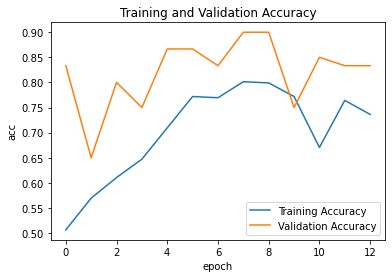

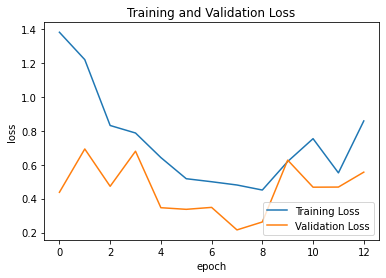

In [39]:
#Visualize training results
acc = plt.plot(NADAM_mod.history['accuracy'])
val_acc = plt.plot(NADAM_mod.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

loss= plt.plot(NADAM_mod.history['loss'])
val_loss=plt.plot(NADAM_mod.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### Observing change in model after we change the learning rate

### Taking example of RMS and changing learning_rate

In [40]:
RMS= RMSprop(learning_rate=0.001)

In [41]:
#instantiate model
model_RMS = cnn_mod()

In [42]:
#Compile the model
model_RMS.compile(optimizer=RMS,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [43]:
#Train the model
RMS_mod = model_RMS.fit_generator(
    train_data_gen,
    epochs=epochs,
    validation_data=test_data_gen,
    callbacks =callbacks
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 84 steps, validate for 3 steps
Epoch 1/20
83/84 [============================>.] - ETA: 0s - loss: 0.7883 - accuracy: 0.6757
Epoch 00001: val_accuracy did not improve from 0.91667
84/84 [==============================] - 42s 501ms/step - loss: 0.7834 - accuracy: 0.6786 - val_loss: 0.3119 - val_accuracy: 0.8667
Epoch 2/20
83/84 [============================>.] - ETA: 0s - loss: 0.3695 - accuracy: 0.8694
Epoch 00002: val_accuracy did not improve from 0.91667
84/84 [==============================] - 40s 479ms/step - loss: 0.3675 - accuracy: 0.8700 - val_loss: 0.4680 - val_accuracy: 0.8333
Epoch 3/20
83/84 [============================>.] - ETA: 0s - loss: 0.2508 - accuracy: 0.9089
Epoch 00003: val_accuracy did not improve from 0.91667
84/84 [==============================] - 40s 473ms/step - loss: 0.2504 - accuracy: 0.9086 - val_loss: 0.3404 - val_accuracy: 0.9000
Epoch 4/20
83/84 [============================>.] - ETA: 0s - loss

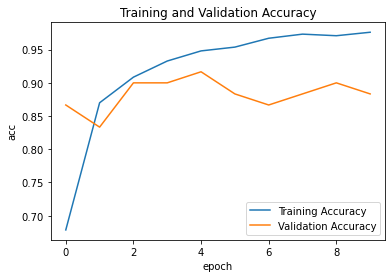

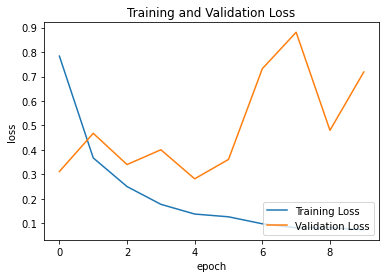

In [44]:
#Visualize training results
acc = plt.plot(RMS_mod.history['accuracy'])
val_acc = plt.plot(RMS_mod.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

loss= plt.plot(RMS_mod.history['loss'])
val_loss=plt.plot(RMS_mod.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()